In [1]:
# data preperation
import numpy as np
import re

data = """Deep learning (also known as deep structured learning) is
part of a broader family of machine learning methods based on
artificial neural networks with representation learning. Learning can
be supervised, semi-supervised or unsupervised. Deep-learning
architectures such as deep neural networks, deep belief networks, deep
reinforcement learning, recurrent neural networks, convolutional
neural networks and Transformers have been applied to fields including
computer vision, speech recognition, natural language processing,
machine translation, bioinformatics, drug design, medical image
analysis, climate science, material inspection and board game
programs, where they have produced results comparable to and in some
cases surpassing human expert performance."""


In [3]:
sentences = data.split('.')

clean_sent = []
for sentence in sentences:
    if sentence == "":
        continue
    sentence = re.sub('[^A-Za-z0-9]+', ' ', (sentence))
    sentence = re.sub(r'(?:^| )\w (?:$| )', ' ', (sentence)).strip()
    sentence = sentence.lower()
    clean_sent.append(sentence)


In [4]:
#tokanize and vocab building
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_sent)
sequences = tokenizer.texts_to_sequences(clean_sent)


In [6]:
#create mapping
index_to_word = {}
word_to_index = {}

for i, sequence in enumerate(sequences):
    word_in_sentence = clean_sent[i].split()
    for j, value in enumerate(sequence):
        index_to_word[value] = word_in_sentence[j]
        word_to_index[word_in_sentence[j]] = value


In [7]:
#generate training data
vocab_size = len(tokenizer.word_index) + 1
emb_size = 10
context_size = 2

contexts = []
targets = []

for sequence in sequences:
    for i in range(context_size, len(sequence) - context_size):
        target = sequence[i]
        context = [sequence[i - 2], sequence[i - 1], sequence[i + 1], sequence[i + 2]]
        contexts.append(context)
        targets.append(target)


In [9]:
#print the training data
for i in range(5):
    words = [index_to_word[j] for j in contexts[i]]
    target = index_to_word[targets[i]]
    print(words, " -> ", target)


['deep', 'learning', 'known', 'as']  ->  also
['learning', 'also', 'as', 'deep']  ->  known
['also', 'known', 'deep', 'structured']  ->  as
['known', 'as', 'structured', 'learning']  ->  deep
['as', 'deep', 'learning', 'is']  ->  structured


In [10]:
# training the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda

X = np.array(contexts)
Y = np.array(targets)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, input_length=2*context_size),
    Lambda(lambda x: tf.reduce_mean(x, axis=1)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=80)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.0096 - loss: 4.3184  
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0927 - loss: 4.3118 
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0362 - loss: 4.3059    
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0558 - loss: 4.2977
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0479 - loss: 4.2842
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0597 - loss: 4.2685
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0714 - loss: 4.2397 
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0714 - loss: 4.2080
Epoch 9/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0518 - loss: 4.1710
Epoch 10/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0323 - loss: 4.1457    
Epoch 11/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0518 - loss: 4.0631 
Epoch 12/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0518 - l

<Axes: >

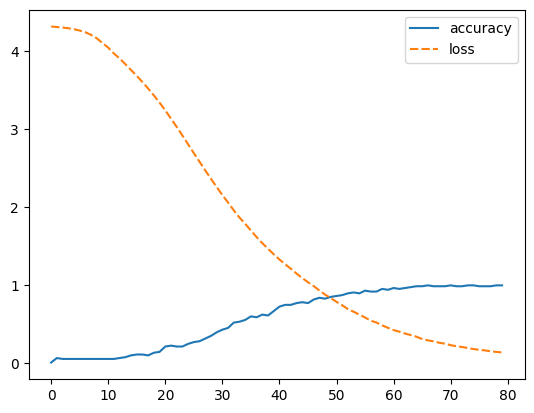

In [11]:
#visualize training process
import seaborn as sns
sns.lineplot(model.history.history)


In [13]:
#model testing
test_sentenses = [
    "known as structured learning",
    "transformers have applied to",
    "where they produced results",
    "cases surpassing expert performance"
]

for sent in test_sentenses:
    test_words = sent.split(" ")
    x_test = [word_to_index.get(i) for i in test_words]
    x_test = np.array([x_test])

    pred = model.predict(x_test)
    pred = np.argmax(pred[0])
    print("pred ", test_words, "\n=", index_to_word.get(pred),"\n\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
pred  ['known', 'as', 'structured', 'learning'] 
= deep 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
pred  ['transformers', 'have', 'applied', 'to'] 
= been 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
pred  ['where', 'they', 'produced', 'results'] 
= have 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
pred  ['cases', 'surpassing', 'expert', 'performance'] 
= human 


